In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from d2d import *

filename = "/data/fast0/datasets/Rhone_data_continuous.h5"
f = h5py.File(filename, 'r')
print("Keys: %s" % f.keys())

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>


In [2]:
# Put data in a data frame
das = np.transpose([chan[750] for chan in f['DAS Data']])

# Might want to try this later:
# das = np.log10(np.transpose([chan[750] for chan in f['DAS Data']]))

discharge = np.array(f['Discharge'])
df = pd.DataFrame(data={'das':das,'discharge':discharge})

Text(0, 0.5, 'Discharge')

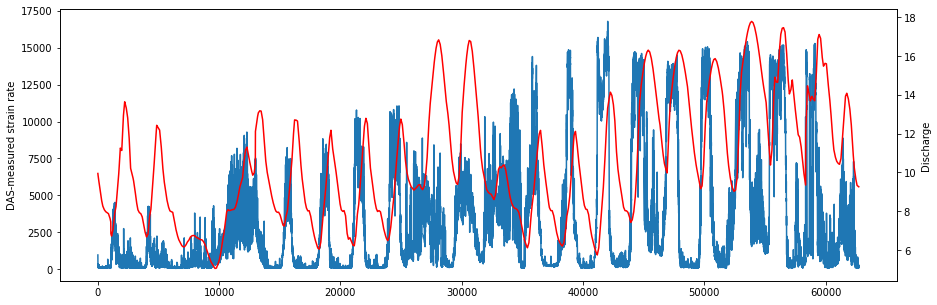

In [3]:
# Plot the raw data

fig,ax=plt.subplots(figsize=(15,5))
ax.plot(das)
ax.set_ylabel('DAS-measured strain rate')
ax2=plt.twinx()
ax2.plot(discharge,'-r')
ax2.set_ylabel('Discharge')

In [4]:
# Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [5]:
# Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

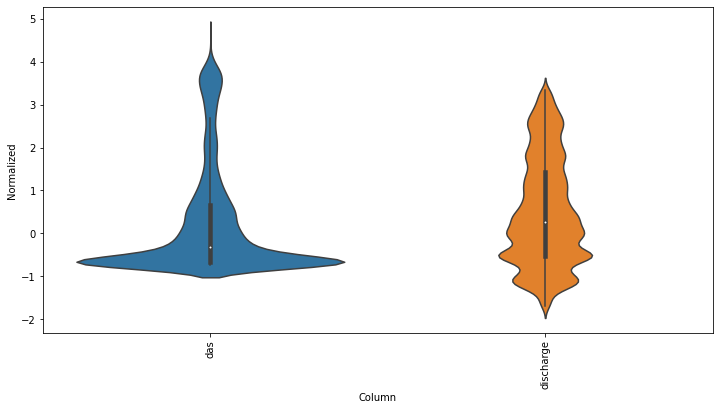

In [6]:
# Visualize the normalized data
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [7]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=0,
    train_df=train_df, 
    val_df=val_df, 
    test_df=test_df,
    label_columns=['discharge'],
    input_columns=['das'])
single_step_window

Total window size: 1
Input indices: [0]
Input column name(s): ['das']
Label indices: [0]
Label column name(s): ['discharge']

In [8]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [9]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [10]:
history = compile_and_fit(linear, single_step_window)

val_performance={}
performance={}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1373/1373 [==============================] - 2s 1ms/step - loss: 0.9875 - mean_absolute_error: 0.7894 - val_loss: 3.5888 - val_mean_absolute_error: 1.6427
Epoch 2/20
1373/1373 [==============================] - 1s 658us/step - loss: 0.9875 - mean_absolute_error: 0.7890 - val_loss: 3.6026 - val_mean_absolute_error: 1.6461
Epoch 3/20
393/393 [==============================] - 0s 484us/step - loss: 3.5963 - mean_absolute_error: 1.6445


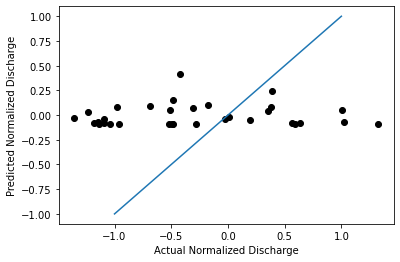

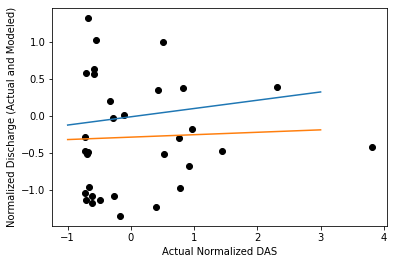

In [11]:
inputs, labels = single_step_window.example

predictions = np.array(linear(inputs)).flatten()
inputs = np.array(inputs).flatten()
labels = np.array(labels).flatten()

plt.subplots()
plt.plot(labels,predictions,'ok')
plt.plot((-1,1),(-1,1))
plt.xlabel('Actual Normalized Discharge')
plt.ylabel('Predicted Normalized Discharge')

plt.subplots()
plt.plot(inputs, labels,'ok')
# for xx, yy in single_step_window.val.take(5):
#     plt.plot(np.array(xx[:,0,:]).flatten(),np.array(yy).flatten(),'or')
plt.xlabel('Actual Normalized DAS')
plt.ylabel('Normalized Discharge (Actual and Modeled)')
weights=linear.layers[0].kernel[:,0].numpy()
biases=linear.layers[0].bias.numpy()
plt.plot((-1,3.0),weights[0]*np.array((-1,3.0))+biases[0])

# Compare to linear least squares
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(inputs,labels)
plt.plot((-1,3.0),slope*np.array((-1,3.0))+intercept)

In [13]:
multi_step_window = WindowGenerator(
    input_width=1000, label_width=1, shift=0,
    train_df=train_df, 
    val_df=val_df, 
    test_df=test_df,
    label_columns=['discharge'],
    input_columns=['das'])
# multi_step_window

In [14]:
history = compile_and_fit(linear, multi_step_window)

Epoch 1/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8526 - mean_absolute_error: 0.7117 - val_loss: 2.4005 - val_mean_absolute_error: 1.3583
Epoch 2/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8428 - mean_absolute_error: 0.7040 - val_loss: 2.3983 - val_mean_absolute_error: 1.3575
Epoch 3/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8428 - mean_absolute_error: 0.7040 - val_loss: 2.3918 - val_mean_absolute_error: 1.3552
Epoch 4/20
1342/1342 [==============================] - 1s 1ms/step - loss: 0.8428 - mean_absolute_error: 0.7040 - val_loss: 2.3887 - val_mean_absolute_error: 1.3540
Epoch 5/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8428 - mean_absolute_error: 0.7040 - val_loss: 2.3896 - val_mean_absolute_error: 1.3543
Epoch 6/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8428 - mean_absolute_error: 0.7040 - val_loss: 2.3919 - val_mean_absolute_error: 1.3552


In [15]:
val_performance['Multistep_Linear'] = linear.evaluate(multi_step_window.val)
performance['Multistep_Linear'] = linear.evaluate(multi_step_window.test, verbose=0)
performance

361/361 [==============================] - 0s 599us/step - loss: 2.3919 - mean_absolute_error: 1.3552


{'Linear': [3.0824642181396484, 1.5439709424972534],
 'Multistep_Linear': [2.409956216812134, 1.3563294410705566]}